Description: This notebook implements a defect detection system using a pre-trained CNN (ResNet50) on the MVTec AD dataset. In this model we are freezing all layers except the last block (layer4) and classifier (fc).


## Step 1: Setup and Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set path to your dataset folder
DATASET_PATH = '/content/drive/MyDrive/CSS586_Visual_Defect_Detection/datasets'


Mounted at /content/drive


### Installing and Importing Required Libraries


In [ ]:
# !pip install torchvision matplotlib scikit-learn
!pip install torch-lr-finder
# Imports
import os
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score

import numpy as np
from PIL import Image
import seaborn as sns


## Step 2: Data Preparation
Since MVTec AD dataset only has `train/good`, `test/good`, `test/defective`, you have to load the MVTec AD dataset fully and then split into train, test and validation datasets using a stratified split.

### Data Augmentation & Transformations

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))  # Conservative defect simulation
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
from torch.utils.data import Dataset
from glob import glob
import os
from PIL import Image

class MVTecBinaryClassificationDataset(Dataset):
    def __init__(self, root_dir=None, item_names='all', transform=None, paths=None, labels=None):
        self.transform = transform
        self.classes = ['good', 'defective']

        # Direct mode: from path-label pairs
        if paths is not None and labels is not None:
            self.samples = paths
            self.labels = labels
            return

        # Otherwise use the default directory-based mode
        self.samples = []
        self.labels = []

        # List all items if 'all' is passed
        if item_names == 'all':
            item_names = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

        if root_dir is None:
            raise ValueError("Must provide either (root_dir and item_names) or (paths and labels).")

        if isinstance(item_names, str):
            item_names = [item_names]  # Make it a list

        for item_name in item_names:
            base_path = os.path.join(root_dir, item_name)

            split = 'train'
            split_path = os.path.join(base_path, split)
            good_images = glob(os.path.join(split_path, 'good', '*.png'))
            self.samples += good_images
            self.labels += [0] * len(good_images)

            split = 'test'
            split_path = os.path.join(base_path, split)
            for defect_type in os.listdir(split_path):
                defect_path = os.path.join(split_path, defect_type)
                if not os.path.isdir(defect_path): continue
                images = glob(os.path.join(defect_path, '*.png'))
                label = 0 if defect_type == 'good' else 1
                self.samples += images
                self.labels += [label] * len(images)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path = self.samples[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Single Item Category Model Training

### Stratified Train-Validation-Test Split
Split the dataset into:

* 80% training

* 10% validation (for early stopping)

* 10% testing (final evaluation)

In [ ]:
from sklearn.model_selection import train_test_split
item_name = 'bottle'  # Change this to the item you are evaluating
root_dir='/content/drive/MyDrive/CSS586_Visual_Defect_Detection/datasets/mvtec_anomaly_detection'

full_dataset = MVTecBinaryClassificationDataset(
    root_dir=root_dir,
    item_names=item_name,
    transform=None
)

class_2_id = {0:'good', 1:'defective'}

image_paths = full_dataset.samples
labels = full_dataset.labels

# First split: Train (80%) and temp (20%)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

# Second split: Val (10%) and Test (10%) from temp
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Check for overlapping images between splits
train_set = set(train_paths)
val_set = set(val_paths)
print(f"Overlapping images: {len(train_set & val_set)}")

# Datasets
train_dataset = MVTecBinaryClassificationDataset(paths=train_paths, labels=train_labels, transform=train_transform)
val_dataset = MVTecBinaryClassificationDataset(paths=val_paths, labels=val_labels, transform=val_test_transform)
test_dataset = MVTecBinaryClassificationDataset(paths=test_paths, labels=test_labels, transform=val_test_transform)

# Optimized DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Show class mapping
print("Class indices:", class_2_id)

Overlapping images: 0
Class indices: {0: 'good', 1: 'defective'}


##Step 3: Utility Functions
Define functions for getting, loading and saving checkpoints and metrics of the model in training.

In [ ]:
import os
import re
import torch

CHECKPOINT_DIR = "/content/drive/MyDrive/CSS586_Visual_Defect_Detection/checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [ ]:
def get_checkpoint_dir(experiment_name):
    base_dir = "/content/drive/MyDrive/CSS586_Visual_Defect_Detection/checkpoints"
    checkpoint_dir = os.path.join(base_dir, experiment_name)
    os.makedirs(checkpoint_dir, exist_ok=True)
    return checkpoint_dir

def load_latest_checkpoint(model, optimizer, experiment_name):
    checkpoint_dir = get_checkpoint_dir(experiment_name)
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith(".pth")]
    if not checkpoints:
        print(f"No checkpoint found for '{experiment_name}'. Starting from scratch.")
        return model, optimizer, 0

    latest = max(checkpoints, key=lambda f: int(re.findall(r'\d+', f)[-1]))
    path = os.path.join(checkpoint_dir, latest)
    print(f"Loading checkpoint from: {path}")
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    return model, optimizer, start_epoch

def save_checkpoint(model, optimizer, epoch, experiment_name):
    checkpoint_dir = get_checkpoint_dir(experiment_name)
    save_path = os.path.join(checkpoint_dir, f'resnet_vdd_epoch_{epoch}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, save_path)
    print(f"Saved checkpoint to: {save_path}")

### Metrics Logging
We track training loss, accuracy, and validation accuracy in a JSON file.



In [ ]:
import json
def get_metrics_path(experiment_name):
    checkpoint_dir = get_checkpoint_dir(experiment_name)
    return os.path.join(checkpoint_dir, "metrics.json")

def save_metrics(train_losses, train_accs, val_accs, experiment_name):
    path = get_metrics_path(experiment_name)
    with open(path, "w") as f:
        json.dump({
            "train_losses": train_losses,
            "train_accs": train_accs,
            "val_accs": val_accs
        }, f)
    print(f"Saved metrics to: {path}")

def load_metrics(experiment_name):
    path = get_metrics_path(experiment_name)
    if os.path.exists(path):
        with open(path, "r") as f:
            data = json.load(f)
        print(f"Loaded existing metrics from: {path}")
        return data["train_losses"], data["train_accs"], data["val_accs"]
    else:
        print(f"No previous metrics found for '{experiment_name}', starting fresh.")
        return [], [], []

## Step 4: Load and Fine-tune the Pre-trained Model

* Freeze all layers except the last block (layer4) and classifier (fc).

* Replace the final layer with a binary classifier (2 classes).



In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pre-trained ResNet-50
#model = models.resnet50(pretrained=True)
model = models.resnet50(weights='IMAGENET1K_V1')  # New way instead of pretrained=True

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze layer4 and fc layers
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
        print(f"Unfreezing layer: {name}")

# Replace the final layer (fc) and layer 4 with a new classifier
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),  # Add dropout with 50% probability
    nn.Linear(num_features, 2) # Same output classes
)

# Move to GPU/CPU
model = model.to(device)

Using device: cuda
Unfreezing layer: layer4.0.conv1.weight
Unfreezing layer: layer4.0.bn1.weight
Unfreezing layer: layer4.0.bn1.bias
Unfreezing layer: layer4.0.conv2.weight
Unfreezing layer: layer4.0.bn2.weight
Unfreezing layer: layer4.0.bn2.bias
Unfreezing layer: layer4.0.conv3.weight
Unfreezing layer: layer4.0.bn3.weight
Unfreezing layer: layer4.0.bn3.bias
Unfreezing layer: layer4.0.downsample.0.weight
Unfreezing layer: layer4.0.downsample.1.weight
Unfreezing layer: layer4.0.downsample.1.bias
Unfreezing layer: layer4.1.conv1.weight
Unfreezing layer: layer4.1.bn1.weight
Unfreezing layer: layer4.1.bn1.bias
Unfreezing layer: layer4.1.conv2.weight
Unfreezing layer: layer4.1.bn2.weight
Unfreezing layer: layer4.1.bn2.bias
Unfreezing layer: layer4.1.conv3.weight
Unfreezing layer: layer4.1.bn3.weight
Unfreezing layer: layer4.1.bn3.bias
Unfreezing layer: layer4.2.conv1.weight
Unfreezing layer: layer4.2.bn1.weight
Unfreezing layer: layer4.2.bn1.bias
Unfreezing layer: layer4.2.conv2.weight
Unfr

## Step 5: Training Loop
Loading and saving checkpoints and metrics.

Implementing early stopping.

Saving final model.

### Loss Function & Optimizer

* Weighted Cross-Entropy Loss (to handle class imbalance)

* AdamW optimizer (with weight decay for regularization)

In [ ]:
import torch.optim as optim

#Compute class counts and weights
class_counts = np.bincount(train_labels)  # e.g., [#good, #defective]
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
class_weights = class_weights / class_weights.sum()  # optional normalization

# Send weights to the correct device
class_weights = class_weights.to(device)

#Define weighted CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=class_weights)
# Apply to model - Weighted decay
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,
    weight_decay=1e-4
)

num_epochs = 10

experiment_name = "single_item_category_fc_transform"

# Load the latest checkpoint and metrics
model, optimizer, start_epoch = load_latest_checkpoint(model, optimizer, experiment_name)
train_losses, train_accs, val_accs = load_metrics(experiment_name)

# Early stopping config
early_stop_patience = 3  # stop if no improvement after 3 epochs
best_val_acc = max(val_accs) if val_accs else 0.0
epochs_no_improve = 0

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    total_loss = 0
    total_train = 0
    correct_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Track training accuracy
        _, preds = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (preds == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)

    train_acc = correct_train / total_train
    train_accs.append(train_acc)

    # --- Validation ---
    model.eval()
    total_val = 0
    correct_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (preds == labels).sum().item()

    val_acc = correct_val / total_val
    val_accs.append(val_acc)

    # Save checkpoint and metrics after each epoch
    save_checkpoint(model, optimizer, epoch+1, experiment_name)
    save_metrics(train_losses, train_accs, val_accs, experiment_name)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss/len(train_loader):.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

    # --- Early Stopping Logic ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No improvement in val_acc for {epochs_no_improve} epoch(s)")

    if epochs_no_improve >= early_stop_patience:
        print(f"Early stopping triggered. Best val_acc: {best_val_acc:.4f}")
        break


Loading checkpoint from: /content/drive/MyDrive/CSS586_Visual_Defect_Detection/checkpoints/single_item_category_fc_transform/resnet_vdd_epoch_10.pth
No previous metrics found for 'single_item_category_fc_transform', starting fresh.
Saved checkpoint to: /content/drive/MyDrive/CSS586_Visual_Defect_Detection/checkpoints/single_item_category_fc_transform/resnet_vdd_epoch_1.pth
Saved metrics to: /content/drive/MyDrive/CSS586_Visual_Defect_Detection/checkpoints/single_item_category_fc_transform/metrics.json
Epoch [1/10] - Loss: 0.0596 - Train Acc: 0.9914 - Val Acc: 1.0000
Saved checkpoint to: /content/drive/MyDrive/CSS586_Visual_Defect_Detection/checkpoints/single_item_category_fc_transform/resnet_vdd_epoch_2.pth
Saved metrics to: /content/drive/MyDrive/CSS586_Visual_Defect_Detection/checkpoints/single_item_category_fc_transform/metrics.json
Epoch [2/10] - Loss: 0.0780 - Train Acc: 0.9871 - Val Acc: 1.0000
No improvement in val_acc for 1 epoch(s)
Saved checkpoint to: /content/drive/MyDrive/C

In [ ]:
# Save full model (architecture + weights)
torch.save(model, '/content/drive/MyDrive/CSS586_Visual_Defect_Detection/models/resnet50_single_item_model_2_tuned1_decay.pth')
print("Model saved to /content/drive/MyDrive/CSS586_Visual_Defect_Detection/models/resnet50_single_item_model_tuned.pth")

Model saved to /content/drive/MyDrive/CSS586_Visual_Defect_Detection/models/resnet50_single_item_model_tuned.pth


## Step 6: Evaluation
Testing and evaluating performance on test set.

Metrics used: Test accuracy, Classification report, Confusion matrix, Precision and Recall.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Convert to arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)

# Results
print(f"Final Test Accuracy: {accuracy*100:.2f}%")

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))



Final Test Accuracy: 96.67%
Classification Report:
              precision    recall  f1-score   support

        good       0.96      1.00      0.98        23
   defective       1.00      0.86      0.92         7

    accuracy                           0.97        30
   macro avg       0.98      0.93      0.95        30
weighted avg       0.97      0.97      0.97        30

Confusion Matrix:
[[23  0]
 [ 1  6]]


## Step 6: Visualization

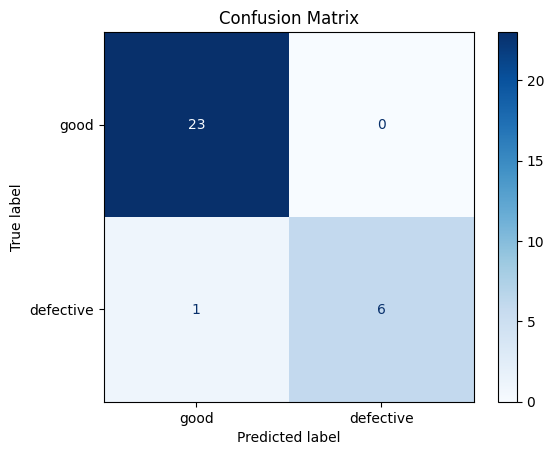

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plot confusion matrix as image
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def show_preds(model, loader, class_names, num_images=5):
    model.eval()
    shown = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                image = inputs[i].cpu().permute(1, 2, 0).numpy()
                image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                image = np.clip(image, 0, 1)

                plt.imshow(image)
                plt.title(f"True: {class_names[labels[i]]} | Pred: {class_names[preds[i]]}")
                plt.axis('off')
                plt.show()

                shown += 1
                if shown >= num_images:
                    return


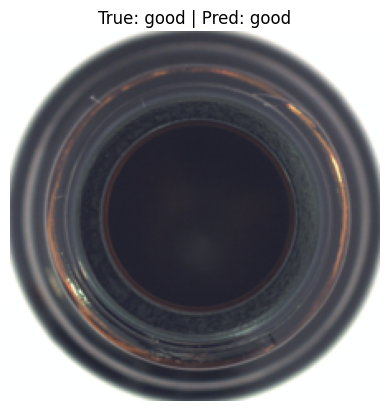

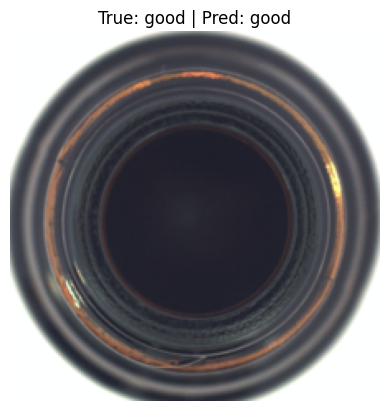

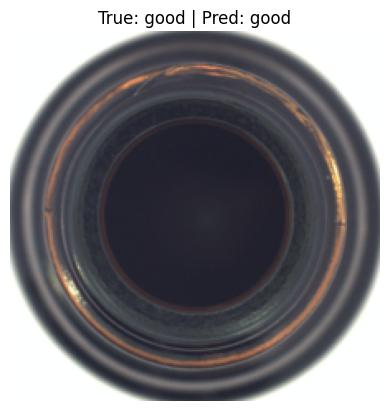

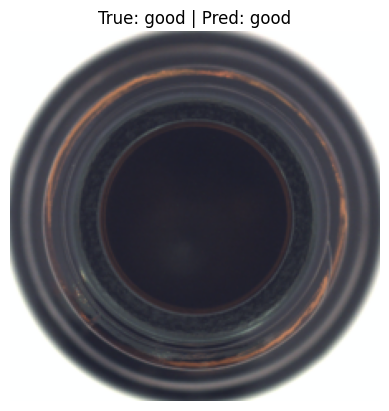

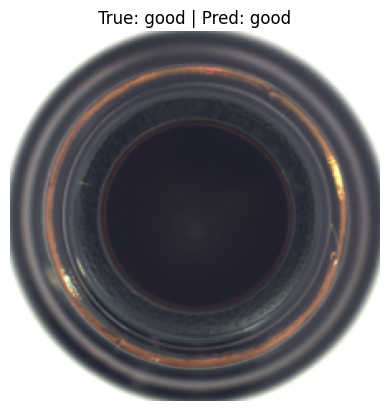

In [ ]:
show_preds(model, test_loader, train_dataset.classes)

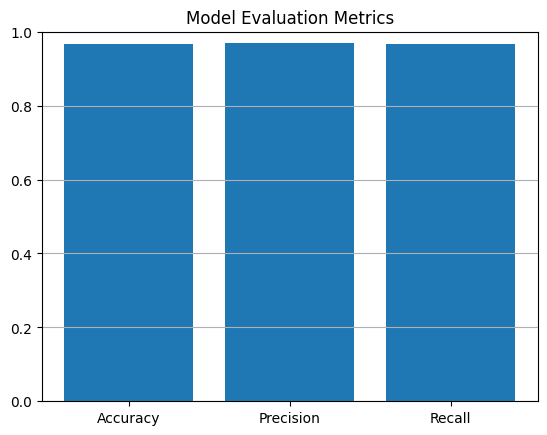

In [ ]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')

plt.bar(['Accuracy', 'Precision', 'Recall'], [accuracy, precision, recall])
plt.title("Model Evaluation Metrics")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()


# Multiple Item Category Training

## Step 2: Data Preparation
Using previously defined MVTecBinaryClassificationDataset class, load data and split into train, validation and test datasets (80:20:20)

In [ ]:
#from torch.utils.data import WeightedRandomSampler

from sklearn.model_selection import train_test_split
item_name = 'all'
root_dir='/content/drive/MyDrive/CSS586_Visual_Defect_Detection/datasets/mvtec_anomaly_detection'

full_dataset = MVTecBinaryClassificationDataset(
    root_dir=root_dir,
    item_names=item_name,
    transform=None
)

class_2_id = {0:'good', 1:'defective'}

image_paths = full_dataset.samples
labels = full_dataset.labels

# First split: Train (80%) and temp (20%)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

# Second split: Val (10%) and Test (10%) from temp
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Check for overlapping images between splits
train_set = set(train_paths)
val_set = set(val_paths)
print(f"Overlapping images: {len(train_set & val_set)}")

# Datasets
train_dataset = MVTecBinaryClassificationDataset(paths=train_paths, labels=train_labels, transform=train_transform)
val_dataset = MVTecBinaryClassificationDataset(paths=val_paths, labels=val_labels, transform=val_test_transform)
test_dataset = MVTecBinaryClassificationDataset(paths=test_paths, labels=test_labels, transform=val_test_transform)

# Optimized DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Show class mapping
print("Classes:", train_dataset.classes)
print("Total Images:", len(train_dataset)+len(val_dataset)+len(test_dataset))
print("Class indices:", class_2_id)

Overlapping images: 0
Classes: ['good', 'defective']
Total Images: 5354
Class indices: {0: 'good', 1: 'defective'}


In [ ]:
from collections import Counter

print("Train:", Counter(train_labels))
print("Val:", Counter(val_labels))
print("Test:", Counter(test_labels))


Train: Counter({0: 3277, 1: 1006})
Val: Counter({0: 409, 1: 126})
Test: Counter({0: 410, 1: 126})


## Step 3: Load and Fine-tune the Pre-trained Model
* Freeze all layers except the last block (layer4) and classifier (fc).

* Replace the final layer with a binary classifier (2 classes).

In [ ]:
from torchvision import models
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pre-trained ResNet-50
model = models.resnet50(weights='IMAGENET1K_V1')  # New way instead of pretrained=True

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze layer4 and fc layers
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
        print(f"Unfreezing layer: {name}")

# Replace classifier
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 classes: defective, good

# Move to GPU/CPU
model = model.to(device)


Using device: cuda
Unfreezing layer: layer4.0.conv1.weight
Unfreezing layer: layer4.0.bn1.weight
Unfreezing layer: layer4.0.bn1.bias
Unfreezing layer: layer4.0.conv2.weight
Unfreezing layer: layer4.0.bn2.weight
Unfreezing layer: layer4.0.bn2.bias
Unfreezing layer: layer4.0.conv3.weight
Unfreezing layer: layer4.0.bn3.weight
Unfreezing layer: layer4.0.bn3.bias
Unfreezing layer: layer4.0.downsample.0.weight
Unfreezing layer: layer4.0.downsample.1.weight
Unfreezing layer: layer4.0.downsample.1.bias
Unfreezing layer: layer4.1.conv1.weight
Unfreezing layer: layer4.1.bn1.weight
Unfreezing layer: layer4.1.bn1.bias
Unfreezing layer: layer4.1.conv2.weight
Unfreezing layer: layer4.1.bn2.weight
Unfreezing layer: layer4.1.bn2.bias
Unfreezing layer: layer4.1.conv3.weight
Unfreezing layer: layer4.1.bn3.weight
Unfreezing layer: layer4.1.bn3.bias
Unfreezing layer: layer4.2.conv1.weight
Unfreezing layer: layer4.2.bn1.weight
Unfreezing layer: layer4.2.bn1.bias
Unfreezing layer: layer4.2.conv2.weight
Unfr

## Step 4: Training Loop
Loading and saving checkpoints and metrics.

Implementing early stopping.

Saving final model.

### Loss Function & Optimizer
* Weighted Cross-Entropy Loss (to handle class imbalance)

* AdamW optimizer (with weight decay for regularization)

In [ ]:
import torch.optim as optim

#Compute class counts and weights
class_counts = np.bincount(train_labels)  # e.g., [#good, #defective]
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
class_weights = class_weights / class_weights.sum()  # optional normalization

# Send weights to the correct device
class_weights = class_weights.to(device)

#Define weighted CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,  # Use the found LR
    weight_decay=1e-4
)

num_epochs = 15
experiment_name = "multi_item_category_layer4_fc_transform"

# Load the latest checkpoint and metrics
model, optimizer, start_epoch = load_latest_checkpoint(model, optimizer, experiment_name)
train_losses, train_accs, val_accs = load_metrics(experiment_name)

# Early stopping config
early_stop_patience = 3  # stop if no improvement after 3 epochs
best_val_acc = max(val_accs) if val_accs else 0.0
epochs_no_improve = 0

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    total_loss = 0
    total_train = 0
    correct_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Track training accuracy
        _, preds = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (preds == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)
    train_acc = correct_train / total_train
    train_accs.append(train_acc)

    # --- Validation ---
    model.eval()
    total_val = 0
    correct_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (preds == labels).sum().item()

    val_acc = correct_val / total_val
    val_accs.append(val_acc)

    # Save checkpoint and metrics after each epoch
    save_checkpoint(model, optimizer, epoch+1, experiment_name)
    save_metrics(train_losses, train_accs, val_accs, experiment_name)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss/len(train_loader):.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

    # --- Early Stopping Logic ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No improvement in val_acc for {epochs_no_improve} epoch(s)")

    if epochs_no_improve >= early_stop_patience:
        print(f"Early stopping triggered. Best val_acc: {best_val_acc:.4f}")
        break


Loading checkpoint from: /content/drive/MyDrive/CSS586_Visual_Defect_Detection/checkpoints/multi_item_category_layer4_fc_transform/resnet_vdd_epoch_10.pth
No previous metrics found for 'multi_item_category_layer4_fc_transform', starting fresh.
Saved checkpoint to: /content/drive/MyDrive/CSS586_Visual_Defect_Detection/checkpoints/multi_item_category_layer4_fc_transform/resnet_vdd_epoch_1.pth
Saved metrics to: /content/drive/MyDrive/CSS586_Visual_Defect_Detection/checkpoints/multi_item_category_layer4_fc_transform/metrics.json
Epoch [1/15] - Loss: 0.2456 - Train Acc: 0.9155 - Val Acc: 0.9383
Saved checkpoint to: /content/drive/MyDrive/CSS586_Visual_Defect_Detection/checkpoints/multi_item_category_layer4_fc_transform/resnet_vdd_epoch_2.pth
Saved metrics to: /content/drive/MyDrive/CSS586_Visual_Defect_Detection/checkpoints/multi_item_category_layer4_fc_transform/metrics.json
Epoch [2/15] - Loss: 0.2181 - Train Acc: 0.9206 - Val Acc: 0.9402
Saved checkpoint to: /content/drive/MyDrive/CSS586

In [ ]:
# Save full model (architecture + weights)
torch.save(model, '/content/drive/MyDrive/CSS586_Visual_Defect_Detection/models/resnet50_multi_item_model_tune2_decay.pth')
print("Model saved to /content/drive/MyDrive/CSS586_Visual_Defect_Detection/models/resnet50_multi_item_model_tune.pth")

Model saved to /content/drive/MyDrive/CSS586_Visual_Defect_Detection/models/resnet50_multi_item_model_tune.pth


## Step 5: Evaluation
Testing and evaluating performance on test set.

Metrics used: Test accuracy, Classification report, Confusion matrix, Precision and Recall.

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Convert to arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)

# Results
print(f"Final Test Accuracy: {accuracy*100:.2f}%")

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

print(" Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Final Test Accuracy: 96.64%
Classification Report:
              precision    recall  f1-score   support

        good       0.97      0.99      0.98       410
   defective       0.96      0.90      0.93       126

    accuracy                           0.97       536
   macro avg       0.96      0.94      0.95       536
weighted avg       0.97      0.97      0.97       536

 Confusion Matrix:
[[405   5]
 [ 13 113]]


## Step 6: Visualization

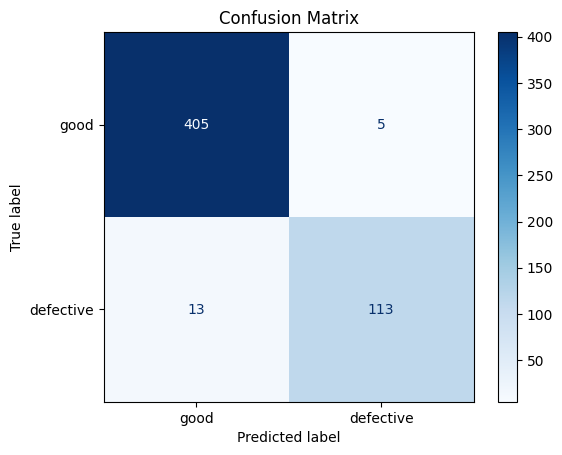

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plot confusion matrix as image
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

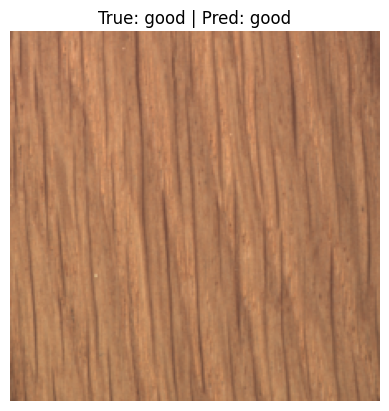

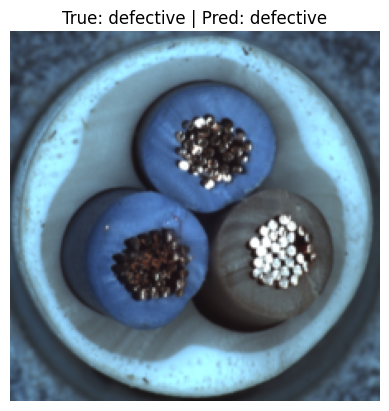

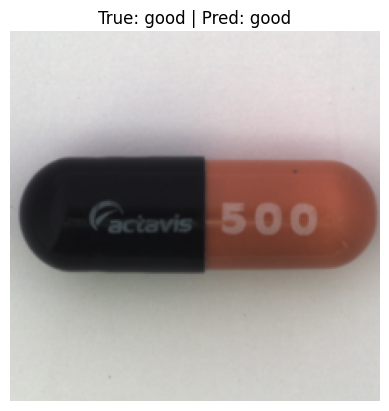

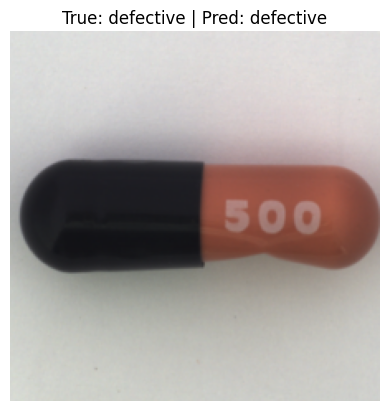

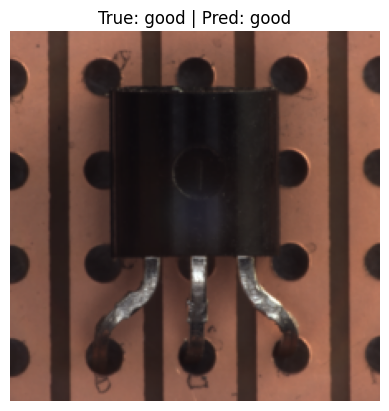

In [ ]:
show_preds(model, test_loader, train_dataset.classes)

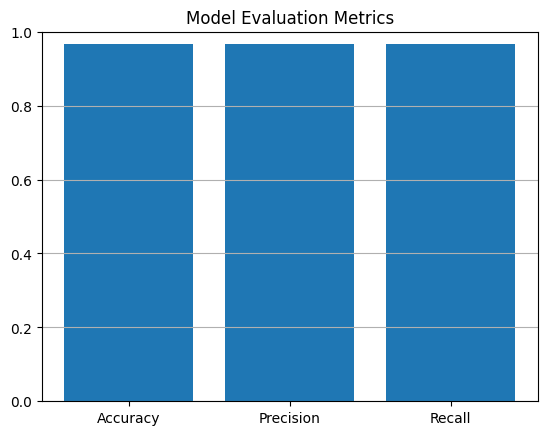

In [ ]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')

plt.bar(['Accuracy', 'Precision', 'Recall'], [accuracy, precision, recall])
plt.title("Model Evaluation Metrics")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()
